# Fianl - AWS - Cycle-General Adversarial Network

### Upload the data required

We use both scans of subjects 1-8 from the PETMR and TRIO dataset for training.

We used the scan of subjects 9-10 also from the PETMR and TRIO dataset for testing.

## FUNCTIONS

In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
import sys
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
import random

/Library/Python/2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#this function simply uploads the testing and training scans into lists of numpy arrays
#the data is not yet sliced or patched at this stage

#specify in a list what scans to use for training and what scans to use for testing


def get_data(petmr_path, trio_path, scans_dict, input_scanner):
    
    train_val_test_inp = []
    train_val_test_out = []
    test_data_inp = []
    test_data_out = []
    # only required for testing scans
    test_data_affine_mat = []
    
    if input_scanner == "PETMR":
        input_path = petmr_path
        output_path = trio_path
    else:
        input_path = trio_path
        output_path = petmr_path       
    
    for key, subjs in scans_dict.iteritems():
        for subj_scan in subjs:
                
            input_scan_image = nib.load(str(input_path) + "/Subj" + str(subj_scan[0]) + "Scan" + str(subj_scan[1]) + "/Brain_Matched.nii.gz")
            input_scan_data = input_scan_image.get_data()
                
            input_bvals_scan, input_bvecs_scan = read_bvals_bvecs(str(input_path) + "/Subj" + str(subj_scan[0]) + "Scan" + str(subj_scan[1]) + "/NODDI.bval",\
                                                          str(input_path) + "/Subj" + str(subj_scan[0]) + "Scan" + str(subj_scan[1]) + "/NODDI.bvec")
            
            # Important : Upload the output scan that is registered to the appropriate input scan
            
            output_scan_image = nib.load(str(output_path) + "/Subj" + str(subj_scan[0]) + "Scan1" + "/Brain_Matched.nii.gz")
            output_scan_data = output_scan_image.get_data()
            
            output_bvals_scan, output_bvecs_scan = read_bvals_bvecs(str(output_path) + "/Subj" + str(subj_scan[0]) + "Scan1/NODDI.bval",\
                                                          str(output_path) + "/Subj" + str(subj_scan[0]) + "Scan1/NODDI.bvec")
                    
            #set a threshold value for b=0 values (due to TRIO dataset)
            input_gtab_scan = gradient_table(input_bvals_scan, input_bvecs_scan, b0_threshold=5)
            input_s0s_scan = input_scan_data[:, :, :, input_gtab_scan.b0s_mask]
                
            output_gtab_scan = gradient_table(output_bvals_scan, output_bvecs_scan, b0_threshold=5)
            output_s0s_scan = output_scan_data[:, :, :, output_gtab_scan.b0s_mask]
            
            # Use only the first volume, ignore other volumes
            if(key == "train_val_test"):
                print ("Uploading Subject %s Scan %s" % (str(subj_scan[0]), str(subj_scan[1])))
                #append the data to the lists containing the training inputs and outputs
                train_val_test_inp.append(input_s0s_scan[:,:,:,[0]])
                train_val_test_out.append(output_s0s_scan[:,:,:,[0]])
            else:
                print ("Testing: Subject %s Scan %s" % (str(subj_scan[0]), str(subj_scan[1])))
                test_data_inp.append(input_s0s_scan[:,:,:,[0]])
                test_data_out.append(output_s0s_scan[:,:,:,[0]])
                test_data_affine_mat.append(input_scan_image.affine)
    return (train_val_test_inp, train_val_test_out, test_data_inp, test_data_out, test_data_affine_mat)

In [3]:
#This function extracts patches from a scan and appends them to a list.
#This is done for all volumes of a scan (for both the inputs and targets)

def patchify(data_scans, patch_size=9, skip=0):
    
    patches_store = []
    padded_scans = []
    
    for scan_no in range(0, len(data_scans)):
        scan = data_scans[scan_no]
        
        # Pad the scan to ensure that the
        (x,y,z,v) = scan.shape
        x_padding = (patch_size - (x % patch_size)) % patch_size
        y_padding = (patch_size - (y % patch_size)) % patch_size
        z_padding = (patch_size - (z % patch_size)) % patch_size
        x_padding_before = x_padding/2
        x_padding_after = x_padding - x_padding_before
        y_padding_before = y_padding/2
        y_padding_after = y_padding - y_padding_before
        z_padding_before = z_padding/2
        z_padding_after = z_padding - z_padding_before
        #pad the input scan
        full_padding = ((x_padding_before, x_padding_after), (y_padding_before, y_padding_after), (z_padding_before, z_padding_after), (0,0))
        padded_scan = np.pad(scan, full_padding, mode='constant', constant_values=0)
        padded_scans.append(padded_scan)
        
        # Get new scan shape
        (x,y,z,v) = padded_scan.shape
        #iterate through each volume to extract the patches
        for volume in range(0, v):
            for pos_x in range(0, x-patch_size+1,skip):
                for pos_y in range(0,y-patch_size+1,skip):
                    for pos_z in range(0, z-patch_size+1,skip):
                        patch = padded_scan[pos_x:pos_x+patch_size, pos_y:pos_y+patch_size, pos_z:pos_z+patch_size, volume]
                        
                        #store the patch and the target
                        patches_store.append(patch)
                        
    return (padded_scans, patches_store)


In [55]:
def viz_pred(inputs, predictions, labels, sliceNo):
    maximum = np.max([inputs.max(), predictions.max(), labels.max()])
    plt.figure
    plt.figure(figsize=(10,10))
    plt.subplot(1, 3, 1).set_axis_off()
    plt.imshow(inputs[:,:,sliceNo,0].T, cmap='gray', origin='lower', vmin=0, vmax=maximum)
    plt.title("Input")
    plt.subplot(1, 3, 2).set_axis_off()
    plt.imshow(predictions[:,:,sliceNo,0].T, cmap='gray', origin='lower', vmin=0, vmax=maximum)
    plt.title("Predicted")
    plt.subplot(1, 3, 3).set_axis_off()
    plt.imshow(labels[:,:,sliceNo,0].T, cmap='gray', origin='lower', vmin=0, vmax=maximum)
    plt.title("Target")
    plt.show()

-------------------------------------------------------------------------------------------------------
---

-------------------------------------------------------------------------------------------------------
---



#### Upload the data

In [67]:
#upload the data
petmr_data_path = '/Volumes/Seagate Backup Plus Drive/Project/Dataset/PETMR_data'
trio_data_path = '/Volumes/Seagate Backup Plus Drive/Project/Dataset/TRIO_data'

# Enter a list of tuples (subject, scan_number)
# Use this to get all scans then split into training, validation and testing
training_scans = [(1,1)]

# This is a final test scan only - used to generate a complete scan from the trained CNN
testing_scans = [(8,1)]

data_dict = {"train_val_test": training_scans, "testing":testing_scans}

(training_inp, training_out, final_test_inp, final_test_out, final_test_affine_mat) = \
        get_data(petmr_data_path, trio_data_path, data_dict, input_scanner="PETMR")
print("Number of scans used for training, validation and testing: %d" % len(training_inp))
print ("Number of scans used for final testing: %d" % len(final_test_inp))

Uploading Subject 1 Scan 1
Testing: Subject 8 Scan 1
Number of scans used for training, validation and testing: 1
Number of scans used for final testing: 1


#### Patchify the data

In [68]:
print "Patchifying training set"
_, training_patches_input = patchify(training_inp, 9, 3)
_, training_patches_target = patchify(training_out, 9, 3)

print "Patchifying final testing scans"
padded_testing_scans_input, testing_patches_input = patchify(final_test_inp, 9, 9)

Patchifying training set
Patchifying final testing scans


In [69]:
print ("Number of training examples : PETMR: %d, TRIO: %d" % (len(training_patches_input), len(training_patches_target)))
print ("Number of final testing examples : %d" % len(testing_patches_input))

Number of training examples : PETMR: 4864, TRIO: 6688
Number of final testing examples : 288


# PyTorch Functions

In [70]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import itertools

In [40]:
#create a dataset class for our data

class MRIdataset(Dataset):
    """MRI b=0 dataset for patches."""

    def __init__(self, patches, transform=None):
        """
        Args:
            patches: patches
            transform (callable, optional): Optional transform to be applied
            on a sample.
        """
        self.patches = patches
        self.transform = transform

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        patch = np.array(self.patches[idx])
        sample = {'patch': patch}

        if self.transform:
            sample = self.transform(sample)
            
        return sample


In [41]:
class To_Tensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        patch = sample['patch']
        
        #first expand dimension because torch expects H x W x D x C
        #currently we only have H x W x D
        aug_patch = np.expand_dims(patch, 3)

        # swap channel axis because
        # numpy: H x W x D x C
        # torch: C x D x H x W
        aug_patch = aug_patch.transpose((3, 2, 0, 1))
        
        return {'patch': torch.Tensor(aug_patch)}



In [10]:
class ImagePool():
    def __init__(self, pool_size):
        self.pool_size = pool_size
        if self.pool_size > 0:
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        if self.pool_size == 0:
            return images
        return_images = []
        for image in images.data:
            image = torch.unsqueeze(image, 0)
            if self.num_imgs < self.pool_size:
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                p = random.uniform(0, 1)
                if p > 0.5:
                    random_id = random.randint(0, self.pool_size-1)
                    tmp = self.images[random_id].clone()
                    self.images[random_id] = image
                    return_images.append(tmp)
                else:
                    return_images.append(image)
        return_images = Variable(torch.cat(return_images, 0))
        return return_images

In [45]:
def train(G_A, G_B, D_A, D_B, MSE_loss, L1_loss, optimizers, schedulers, trainloader_inp, trainloader_tar, epochs):
    G_optimizer = optimizers[0]
    D_A_optimizer = optimizers[1]
    D_B_optimizer = optimizers[2]
    G_scheduler = schedulers[0]
    D_A_scheduler = schedulers[1]
    D_B_scheduler = schedulers[2]
    
    # Generated image pool
    num_pool = 50
    fake_A_pool = ImagePool(num_pool)
    fake_B_pool = ImagePool(num_pool)

    G_A.train()
    G_B.train()
    D_A.train()
    D_B.train()
    
    for epoch in range(epochs):
        D_A_losses = []
        D_B_losses = []
        G_A_losses = []
        G_B_losses = []
        cycle_A_losses = []
        cycle_B_losses = []
        
        running_D_A_loss = 0
        running_D_B_loss = 0
        running_G_A_loss = 0
        running_G_B_loss = 0
        running_G_loss = 0
        running_cycle_A_loss = 0
        running_cycle_B_loss =0

        # training
        for i, (data_inp, data_tar) in enumerate(zip(trainloader_inp, trainloader_tar)):

            # input image data
            real_A = data_inp['patch']
            real_B = data_tar['patch']

            real_A = Variable(real_A)
            real_B = Variable(real_B)

            # Train generator G
            # A -> B
            fake_B = G_A(real_A)
            D_B_fake_decision = D_B(fake_B)
            
            G_A_loss = MSE_loss(D_B_fake_decision, Variable(torch.ones(D_B_fake_decision.size())))
            running_G_A_loss += G_A_loss.data[0]

            # forward cycle loss
            recon_A = G_B(fake_B)
            cycle_A_loss = L1_loss(recon_A, real_A) * 5
            running_cycle_A_loss += cycle_A_loss.data[0]

            # B -> A
            fake_A = G_B(real_B)
            D_A_fake_decision = D_A(fake_A)
            G_B_loss = MSE_loss(D_A_fake_decision, Variable(torch.ones(D_A_fake_decision.size())))
            running_G_B_loss += G_B_loss.data[0]

            # backward cycle loss
            recon_B = G_A(fake_A)
            cycle_B_loss = L1_loss(recon_B, real_B) * 5
            running_cycle_B_loss += cycle_B_loss.data[0]

            # Back propagation
            G_loss = G_A_loss + G_B_loss + cycle_A_loss + cycle_B_loss
            running_G_loss += G_loss.data[0]
            G_optimizer.zero_grad()
            G_loss.backward()
            G_optimizer.step()

            # Train discriminator D_A
            D_A_real_decision = D_A(real_A)
            D_A_real_loss = MSE_loss(D_A_real_decision, Variable(torch.ones(D_A_real_decision.size())))
            fake_A = fake_A_pool.query(fake_A)
            D_A_fake_decision = D_A(fake_A)
            D_A_fake_loss = MSE_loss(D_A_fake_decision, Variable(torch.zeros(D_A_fake_decision.size())))

            # Back propagation
            D_A_loss = (D_A_real_loss + D_A_fake_loss) * 0.5
            running_D_A_loss += D_A_loss.data[0]
            D_A_optimizer.zero_grad()
            D_A_loss.backward()
            D_A_optimizer.step()

            # Train discriminator D_B
            D_B_real_decision = D_B(real_B)
            D_B_real_loss = MSE_loss(D_B_real_decision, Variable(torch.ones(D_B_real_decision.size())))
            fake_B = fake_B_pool.query(fake_A)
            D_B_fake_decision = D_B(fake_B)
            D_B_fake_loss = MSE_loss(D_B_fake_decision, Variable(torch.zeros(D_B_fake_decision.size())))

            # Back propagation
            D_B_loss = (D_B_real_loss + D_B_fake_loss) * 0.5
            running_D_B_loss += D_B_loss.data[0]
            D_B_optimizer.zero_grad()
            D_B_loss.backward()
            D_B_optimizer.step()
            
            # loss values
            D_A_losses.append(running_D_A_loss/(i+1))
            D_B_losses.append(running_D_B_loss/(i+1))
            G_A_losses.append(running_G_A_loss/(i+1))
            G_B_losses.append(running_G_B_loss/(i+1))
            cycle_A_losses.append(running_cycle_A_loss/(i+1))
            cycle_B_losses.append(running_cycle_B_loss/(i+1))
            
            if i%1000 == 999:
                print('Epoch [%d/%d], Step [%d/%d], D_A_loss: %.4f, D_B_loss: %.4f, G_A_loss: %.4f, G_B_loss: %.4f'
                  % (epoch+1, epochs, i+1, len(trainloader_inp), running_D_A_loss/(i+1), running_D_B_loss/(i+1), running_G_A_loss/(i+1), running_G_B_loss/(i+1)))
        
        # Change learning rate using the scheduler
        G_scheduler.step(running_G_loss/(i+1))
        D_A_scheduler.step(running_D_A_loss/(i+1))
        D_B_scheduler.step(running_D_B_loss/(i+1))
        
    return  (D_A_losses, D_B_losses, G_A_losses, G_B_losses, cycle_A_losses, cycle_B_losses)

In [27]:
def plt_losses(training_losses, validation_losses):
    plt.figure
    plt.plot(range(1,len(training_losses)+1), training_losses, 'r-', label="Training error")
    plt.plot(range(1,len(validation_losses)+1), validation_losses, 'b-', label="Validation error")
    plt.legend()
    plt.xlabel('iteration')
    # Make the y-axis label, ticks and tick labels match the line color.
    plt.ylabel('Loss - (MSE)')
    plt.show()

In [89]:
def get_predictions(G_A, testloader):
    G_A.eval()
    for i, test_data in enumerate(testloader, 0):
        real_A = test_data['patch']
        real_A = Variable(real_A)

        # A -> B
        test_predictions = G_A(real_A)

        #store the predictions in a numpy array which we can reshape later
        if(i == 0):
            predictions = test_predictions.data.cpu().numpy() 
        else:
            predictions = np.concatenate((predictions, test_predictions.data.cpu().numpy()), axis=0)

    # Transpose predictions from (NxCxDxHxW)
    # to (NxCxHxWxD)
    predictions = np.transpose(predictions, (0,1,3,4,2))
    return predictions

In [79]:
def reconstruct_brain(predictions, scans, patch_size):
    # Scans is a list containing the input scans where each scan is stored as a 4d numpy array
    # Iterate through all the scans and reconstruct them
    i = 0
    reconstructed_scans = []
    for scan in scans:
        dimensions = scan.shape
        size_x = dimensions[0]
        size_y = dimensions[1]
        size_z = dimensions[2]
        size_v = dimensions[3]
        predicted_scan = np.zeros((size_x, size_y, size_z, size_v))
        
        for volume in range(0, size_v):
            for pos_x in range(0, size_x-patch_size+1, patch_size):
                for pos_y in range(0,size_y-patch_size+1, patch_size):
                    for pos_z in range(0, size_z-patch_size+1, patch_size):
                        predicted_scan[pos_x:pos_x+patch_size, pos_y:pos_y+patch_size, pos_z:pos_z+patch_size, volume] = predictions[i,0,:,:,:]
                        i += 1

        reconstructed_scans.append(predicted_scan)
        
    return reconstructed_scans

-------------------------------------------------------------------------------------------------------
---

-------------------------------------------------------------------------------------------------------
---



### Upload the data using pytorch data loaders

In [71]:
training_dataset_inputs = MRIdataset(training_patches_input, transform=transforms.Compose([To_Tensor()]))
training_dataset_targets = MRIdataset(training_patches_target, transform=transforms.Compose([To_Tensor()]))

final_testing_dataset = MRIdataset(testing_patches_input, transform=transforms.Compose([To_Tensor()]))

In [72]:
trainloader_inp = DataLoader(training_dataset_inputs, batch_size=2,
                        shuffle=True, num_workers=1)

trainloader_tar = DataLoader(training_dataset_targets, batch_size=2,
                        shuffle=True, num_workers=1)

final_test_loader = DataLoader(final_testing_dataset, batch_size=1,
                        shuffle=False, num_workers=1)

# Develop GAN

In [32]:
class ConvBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=3, stride=1, padding=0, activation='relu', batch_norm=True):
        super(ConvBlock, self).__init__()
        self.conv = torch.nn.Conv3d(input_size, output_size, kernel_size, stride, padding)
        self.batch_norm = batch_norm
        self.bn = torch.nn.BatchNorm3d(output_size)
        self.activation = activation
        self.relu = torch.nn.ReLU(True)
        self.lrelu = torch.nn.LeakyReLU(0.2, True)
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        if self.batch_norm:
            out = self.bn(self.conv(x))
        else:
            out = self.conv(x)

        if self.activation == 'relu':
            return self.relu(out)
        elif self.activation == 'lrelu':
            return self.lrelu(out)
        elif self.activation == 'tanh':
            return self.tanh(out)
        elif self.activation == 'no_act':
            return out


class DeconvBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=3, stride=1, padding=0, output_padding=0, activation='relu', batch_norm=True):
        super(DeconvBlock, self).__init__()
        self.deconv = torch.nn.ConvTranspose3d(input_size, output_size, kernel_size, stride, padding, output_padding)
        self.batch_norm = batch_norm
        self.bn = torch.nn.BatchNorm3d(output_size)
        self.activation = activation
        self.relu = torch.nn.ReLU(True)

    def forward(self, x):
        if self.batch_norm:
            out = self.bn(self.deconv(x))
        else:
            out = self.deconv(x)

        if self.activation == 'relu':
            return self.relu(out)
        elif self.activation == 'lrelu':
            return self.lrelu(out)
        elif self.activation == 'tanh':
            return self.tanh(out)
        elif self.activation == 'no_act':
            return out


class ResnetBlock(torch.nn.Module):
    def __init__(self, num_filter, kernel_size=3, stride=1, padding=1):
        super(ResnetBlock, self).__init__()
        self.conv1 = torch.nn.Conv3d(num_filter, num_filter, kernel_size, stride, padding)
        self.conv2 = torch.nn.Conv3d(num_filter, num_filter, kernel_size, stride, padding)
        self.bn = torch.nn.BatchNorm3d(num_filter)
        self.relu = torch.nn.ReLU(True)

        self.resnet_block = torch.nn.Sequential(
            self.conv1,
            self.bn,
            self.relu,
            self.conv2,
            self.bn
        )

    def forward(self, x):
        residual = x
        out = self.resnet_block(x)
        out += residual
        out = self.relu(out)
        return out


class Generator(torch.nn.Module):
    def __init__(self, input_dim, num_filter, output_dim, num_resnet):
        super(Generator, self).__init__()

        # Encoder
        self.conv1 = ConvBlock(input_dim, num_filter)
        self.conv2 = ConvBlock(num_filter, num_filter * 2)
        self.conv3 = ConvBlock(num_filter * 2, num_filter * 4)
        # Resnet blocks
        self.resnet_blocks = []
        for i in range(num_resnet):
            self.resnet_blocks.append(ResnetBlock(num_filter * 4))
        self.resnet_blocks = torch.nn.Sequential(*self.resnet_blocks)
        # Decoder
        self.deconv1 = DeconvBlock(num_filter * 4, num_filter * 2)
        self.deconv2 = DeconvBlock(num_filter * 2, num_filter)
        self.deconv3 = DeconvBlock(num_filter, output_dim, batch_norm=False)

    def forward(self, x):
        # Encoder
        enc1 = self.conv1(x)
        enc2 = self.conv2(enc1)
        enc3 = self.conv3(enc2)
        # Resnet blocks
        res = self.resnet_blocks(enc3)
        # Decoder
        dec1 = self.deconv1(res)
        dec2 = self.deconv2(dec1)
        out = self.deconv3(dec2)
        return out

    def normal_weight_init(self, mean=0.0, std=0.02):
        for m in self.children():
            if isinstance(m, ConvBlock):
                torch.nn.init.normal(m.conv.weight, mean, std)
            if isinstance(m, DeconvBlock):
                torch.nn.init.normal(m.deconv.weight, mean, std)
            if isinstance(m, ResnetBlock):
                torch.nn.init.normal(m.conv.weight, mean, std)
                torch.nn.init.constant(m.conv.bias, 0)


class Discriminator(torch.nn.Module):
    def __init__(self, input_dim, num_filter, output_dim):
        super(Discriminator, self).__init__()

        conv1 = ConvBlock(input_dim, num_filter, activation='lrelu', batch_norm=False)
        conv2 = ConvBlock(num_filter, num_filter * 4, activation='lrelu')
        conv3 = ConvBlock(num_filter * 4, output_dim, activation='no_act', batch_norm=False)

        self.conv_blocks = torch.nn.Sequential(
            conv1,
            conv2,
            conv3,
        )

    def forward(self, x):
        out = self.conv_blocks(x)
        return out

    def normal_weight_init(self, mean=0.0, std=0.02):
        for m in self.children():
            if isinstance(m, ConvBlock):
                torch.nn.init.normal(m.conv.weight, mean, std)
    


In [33]:
# Define nets and initialise their weigths
G_A = Generator(1, 1, 1, 0)
G_B = Generator(1, 1, 1, 0)
D_A = Discriminator(1, 1, 1)
D_B = Discriminator(1, 1, 1)
G_A.normal_weight_init(mean=0.0, std=0.02)
G_B.normal_weight_init(mean=0.0, std=0.02)
D_A.normal_weight_init(mean=0.0, std=0.02)
D_B.normal_weight_init(mean=0.0, std=0.02)

#G_A.cuda()
#G_B.cuda()
#D_A.cuda()
#D_B.cuda()


### Define loss function and optimization algorithm

In [34]:
# Loss function
MSE_loss = nn.MSELoss()
L1_loss = nn.L1Loss()

# optimizers
G_optimizer = torch.optim.Adam(itertools.chain(G_A.parameters(), G_B.parameters()), lr=0.01)
D_A_optimizer = torch.optim.Adam(D_A.parameters(), lr=0.01)
D_B_optimizer = torch.optim.Adam(D_B.parameters(), lr=0.01)

G_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(G_optimizer, 'min', patience=0, verbose=True, threshold=0.08)
D_A_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(D_A_optimizer, 'min', patience=0, verbose=True, threshold=0.08)
D_B_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(D_B_optimizer, 'min', patience=0, verbose=True, threshold=0.08)

optimizers = [G_optimizer, D_A_optimizer, D_B_optimizer]
schedulers = [G_scheduler, D_A_scheduler, D_B_scheduler]

In [35]:
D_A_avg_losses = []
D_B_avg_losses = []
G_A_avg_losses = []
G_B_avg_losses = []
cycle_A_avg_losses = []
cycle_B_avg_losses = []

### Train CNN

In [46]:
losses = train(G_A, G_B, D_A, D_B, MSE_loss, L1_loss, optimizers, schedulers, trainloader_inp, trainloader_tar, 1)

Epoch [1/1], Step [1000/2432], D_A_loss: 0.0964, D_B_loss: 0.0909, G_A_loss: 0.1949, G_B_loss: 0.7390
Epoch [1/1], Step [2000/2432], D_A_loss: 0.0672, D_B_loss: 0.0634, G_A_loss: 0.1589, G_B_loss: 0.8161


In [90]:
final_test_predictions = get_predictions(G_A, final_test_loader)

In [91]:
final_predicted_brains = reconstruct_brain(final_test_predictions, padded_testing_scans_input, 9)

### Visualise predictions

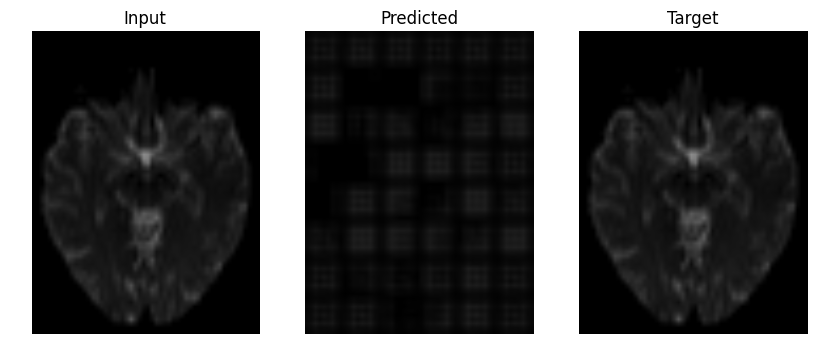

In [92]:
viz_pred(padded_testing_scans_input[0], final_predicted_brains[0], padded_testing_scans_input[0], 20)

In [ ]:
viz_diff(final_predicted_brains[0], final_test_inp[0], final_test_out1[0], 25)

## Save the target and the predicted scans

In [ ]:
save_to = "/home/ubuntu/project/Dataset/Final_AWS_1"

predicted_scan = nib.Nifti1Image(final_predicted_brain, affine_mat)
nib.save(predicted_scan, save_to + "/Predicted_Subj9Scan2_AWS.nii.gz" )

## Store the model parameters

In [ ]:
torch.save(trained_net.state_dict(), '/home/ubuntu/project/MRIDataHarmonisation/Development/Model_Params_AWS/Final_Model_FC.pth') 

## Load the model parameters

In [ ]:
trained_net = Net()
trained_net.cuda()
trained_net.load_state_dict(torch.load('/home/ubuntu/project/MRIDataHarmonisation/Development/Model_Params_AWS/Final_Model_FC.pth'))